[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UNSW-COMP9418/Week10/blob/main/COMP9418_W10_Graph_Neural_Nets_and_Embeddings_Solutions.ipynb)

# Graph Neural Nets and Embeddings

**COMP9418 W10 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Notebook designed by Gustavo Batista
- Last Update 31st July 2025

# Graph Neural Network Analysis on the Cora Dataset

## Motivation

Graphs are a powerful representation for relational data, capturing the dependencies between entities (nodes) through their connections (edges). Traditional machine learning models typically ignore this structure, treating each sample independently. In contrast, **Graph Neural Networks (GNNs)** leverage both node features and graph structure to learn powerful representations for tasks like node classification, link prediction, and graph classification.

In this tutorial, we will study the task of **node classification** using the **Cora citation network**, a widely used benchmark dataset in graph learning. Each node in the graph represents a scientific publication, with edges denoting citation links. Node features are derived from the text content, and the goal is to predict the research area (class) of each paper.

## Objectives

This tutorial will guide you through the complete pipeline for GNN-based node classification:

- **Data Preparation**: Load and preprocess the Cora dataset, construct the graph, and create train/validation/test splits.
- **Exploratory Data Analysis (EDA)**: Visualize class distributions and feature embeddings using t-SNE.
- **Baseline Model**: Implement and evaluate a shallow encoder that learns node embeddings independently of graph structure.
- **Node2Vec**: Generate node embeddings via biased random walks and evaluate their performance.
- **Graph Convolutional Network (GCN)**: Implement a simple two-layer GCN and analyze its performance relative to the baselines.
- **Performance Comparison**: Summarize the results across all models and visualize their accuracy.

## Key Takeaways

- Understand the differences between non-structural (MLP), structural (Node2Vec), and graph-convolution-based models.
- Learn how random walks and convolutional propagation affect the learned embeddings.
- Gain hands-on experience with TensorFlow-based implementations of GNNs from scratch.

## Library Installation

This tutorial requires several Python libraries for scientific computing, visualization, and neural network training. If you are running this notebook on your machine and do not already have these libraries installed, you can install them via `pip`:


```pip install numpy scipy matplotlib seaborn scikit-learn tensorflow```

If you are using a managed environment like Google Colab, most of these packages are pre-installed. However, TensorFlow might require an upgrade to version 2.x using:

```pip install --upgrade tensorflow```

In [4]:
# Only run this cell if you do not want to use your libraries and
# prefer to download our implementation from GitHub

import urllib.request

base_url = "https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/"
files = ["Graph.py"]

for file in files:
    url = base_url + file
    print(f"Downloading {file}...")
    urllib.request.urlretrieve(url, file)

In [5]:
# =============================================================================
# LIBRARY IMPORTS
# =============================================================================

import os
import urllib.request
import pickle
import random

import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Embedding, Dense, Input
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

from Graph import Graph

# Set seaborn style
sns.set(style="whitegrid")

## Loading the Cora Dataset

The Cora dataset is a citation network where:
- Each **node** represents a scientific publication.
- Each **edge** represents a citation link from one paper to another.
- Each node is annotated with:
  - A **feature vector** representing word occurrences from the paper’s text (TF-IDF).
  - A **class label** indicating its topic.

We will use the Planetoid version of the dataset, which is commonly used in graph learning benchmarks. If the dataset is not already present locally, we will download the necessary files from the GitHub repository maintained by the original authors.

The dataset comes as several `.x`, `.y`, `.allx`, `.ally`, `.graph`, and `.test.index` files, which we’ll load and merge into a single feature matrix, label array, and adjacency list representation of the graph.

In [6]:
# =============================================================================
# DOWNLOAD AND LOAD CORA DATASET
# =============================================================================

def download_cora_dataset():
    """Download Cora dataset files from Planetoid repository."""
    url = "https://github.com/kimiyoung/planetoid/raw/master/data"
    files = [
        "ind.cora.x", "ind.cora.tx", "ind.cora.allx",
        "ind.cora.y", "ind.cora.ty", "ind.cora.ally",
        "ind.cora.graph", "ind.cora.test.index"
    ]
    os.makedirs("cora_data", exist_ok=True)
    
    for filename in files:
        full_path = os.path.join("cora_data", filename)
        if not os.path.exists(full_path):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(f"{url}/{filename}", full_path)
        else:
            print(f"{filename} already exists.")

def load_pickle_file(filepath):
    """Load pickle file with latin1 encoding."""
    with open(filepath, 'rb') as f:
        return pickle.load(f, encoding='latin1')

def load_cora_data():
    """Load and preprocess Cora dataset."""
    data_dir = "cora_data"

    # Load dataset parts
    x_train = load_pickle_file(f"{data_dir}/ind.cora.x")
    x_test = load_pickle_file(f"{data_dir}/ind.cora.tx")
    x_all = load_pickle_file(f"{data_dir}/ind.cora.allx")
    y_train = load_pickle_file(f"{data_dir}/ind.cora.y")
    y_test = load_pickle_file(f"{data_dir}/ind.cora.ty")
    y_all = load_pickle_file(f"{data_dir}/ind.cora.ally")
    graph = load_pickle_file(f"{data_dir}/ind.cora.graph")
    test_indices = np.loadtxt(f"{data_dir}/ind.cora.test.index", dtype=int)

    # Number of nodes in the graph
    num_nodes = max(graph.keys()) + 1

    # Assemble full feature matrix
    X_features = sp.lil_matrix((num_nodes, x_all.shape[1]))
    X_features[:x_all.shape[0]] = x_all
    for i, idx in enumerate(test_indices):
        X_features[idx] = x_test[i]

    # Assemble full label matrix
    Y_labels = np.zeros((num_nodes, y_all.shape[1]))
    Y_labels[:y_all.shape[0]] = y_all
    for i, idx in enumerate(test_indices):
        Y_labels[idx] = y_test[i]

    return X_features, Y_labels, graph, num_nodes

# Trigger dataset download and loading
print("=== LOADING CORA DATASET ===")
download_cora_dataset()
X_features, Y_labels, graph_dict, num_nodes = load_cora_data()

=== LOADING CORA DATASET ===
ind.cora.x already exists.
ind.cora.tx already exists.
ind.cora.allx already exists.
ind.cora.y already exists.
ind.cora.ty already exists.
ind.cora.ally already exists.
ind.cora.graph already exists.
ind.cora.test.index already exists.


/var/folders/br/rz4cslwn0q9358rpx_5qjbqm0000gp/T/ipykernel_93103/1205765912.py:26: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  return pickle.load(f, encoding='latin1')


## Exploring the Raw Cora Dataset

Before diving into preprocessing, let's explore the raw components of the Cora dataset to understand its structure:

- `x`, `tx`, `allx`: Sparse feature matrices.
- `y`, `ty`, `ally`: One-hot encoded label matrices.
- `graph`: A dictionary mapping each node to a list of neighbors.
- `test.index`: List of indices used as test set in the original split.

We'll inspect:
- The shape and type of the feature and label matrices.
- An example entry from the graph structure.
- What the label vectors and feature vectors look like.

In [7]:
# Inspect shapes and types
print(f"x_all shape: {X_features.shape}")
print(f"y_all shape: {Y_labels.shape}")
print(f"Number of nodes in graph: {len(graph_dict)}")
print(f"Example node ID: {list(graph_dict.keys())[0]}")
print(f"Neighbors of node 0: {graph_dict[0]}")

# Inspect node features (sparse vector)
sample_node = 0
print(f"\nNode {sample_node} feature vector (non-zero indices):")
print(np.nonzero(X_features[sample_node])[1])

# Inspect one-hot encoded labels
print(f"\nNode {sample_node} label (one-hot):")
print(Y_labels[sample_node])
print(f"Node {sample_node} label (class index): {np.argmax(Y_labels[sample_node])}")

x_all shape: (2708, 1433)
y_all shape: (2708, 7)
Number of nodes in graph: 2708
Example node ID: 0
Neighbors of node 0: [633, 1862, 2582]

Node 0 feature vector (non-zero indices):
[  19   81  146  315  774  877 1194 1247 1274]

Node 0 label (one-hot):
[0. 0. 0. 1. 0. 0. 0.]
Node 0 label (class index): 3


## Visualizing Graph Structure and Labels

Before we preprocess the dataset, let's visualize two important aspects:

1. **Class Distribution**: How many nodes belong to each class?
2. **Node Degree Distribution**: How many connections (edges) each node has?

These give us insights into:
- Whether the classification task is imbalanced.
- Whether the graph is sparse or dense, and whether degree heterogeneity might affect learning.

/var/folders/br/rz4cslwn0q9358rpx_5qjbqm0000gp/T/ipykernel_93103/3499697509.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_labels, palette="tab10")


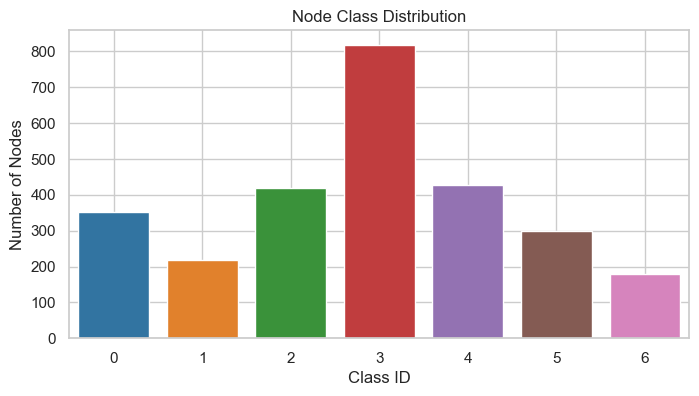

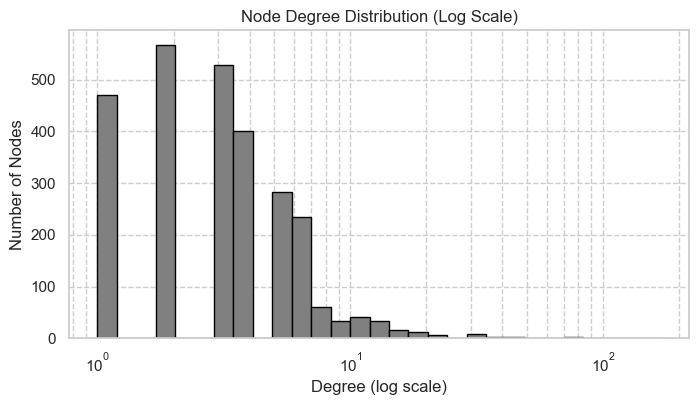

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Convert one-hot to class labels
y_labels = np.argmax(Y_labels, axis=1)

# Plot class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=y_labels, palette="tab10")
plt.title("Node Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()

# Compute node degrees
degrees = [len(neighbors) for node, neighbors in graph_dict.items()]

# Plot degree distribution with log-scaled x-axis
plt.figure(figsize=(8, 4))
plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)+1), 30),
         color='gray', edgecolor='black')
plt.xscale('log')
plt.title("Node Degree Distribution (Log Scale)")
plt.xlabel("Degree (log scale)")
plt.ylabel("Number of Nodes")
plt.grid(True, which="both", ls="--")
plt.show()

## Data Preprocessing

To prepare the dataset for learning, we perform the following steps:

1. **Feature Normalization**: Normalize node feature vectors using L2 norm. This ensures uniform scale across nodes.
2. **Label Conversion**: Convert one-hot encoded labels into integer class IDs.
3. **Adjacency Matrix Construction**: Convert the dictionary-based graph into a sparse adjacency matrix.
4. **Symmetrization**: Since the citation graph is undirected, we ensure the adjacency matrix is symmetric.

This preprocessing is necessary for both baseline models and graph neural networks.

In [11]:
def preprocess_data(X_features, Y_labels, graph):
    """Normalize features, convert labels, and build sparse adjacency matrix."""
    
    # Normalize node features (L2 norm per row)
    X_normalized = normalize(X_features, norm='l2', axis=1)
    
    # Convert one-hot labels to integers
    y_labels = np.argmax(Y_labels, axis=1)
    
    # Build adjacency matrix
    num_nodes = X_normalized.shape[0]
    adj_matrix = sp.lil_matrix((num_nodes, num_nodes))
    for src, neighbors in graph.items():
        for dst in neighbors:
            adj_matrix[src, dst] = 1
            adj_matrix[dst, src] = 1  # Make symmetric (undirected graph)
    
    return X_normalized, y_labels, adj_matrix

# Run preprocessing
X_normalized, y_labels, adj_matrix = preprocess_data(X_features, Y_labels, graph_dict)

# Display basic info
print(f"Feature matrix shape: {X_normalized.shape}")
print(f"Adjacency matrix shape: {adj_matrix.shape}")
print(f"Number of edges: {adj_matrix.nnz // 2}")  # undirected

Feature matrix shape: (2708, 1433)
Adjacency matrix shape: (2708, 2708)
Number of edges: 5278


## Creating Train, Validation, and Test Splits

To evaluate our models properly, we divide the dataset into three disjoint sets:

- **Training set**: Used to fit the model parameters.
- **Validation set**: Used to tune hyperparameters and monitor overfitting.
- **Test set**: Used to evaluate final model performance on unseen data.

We perform **stratified sampling**, ensuring that the class distribution is preserved across all splits. This is crucial for imbalanced datasets like Cora.

The typical split used in GNN literature is:

- 50-60% for training + validation
- 30-40% for testing
- Of the training + validation, 20% used for validation

In [12]:
def create_train_val_test_split(num_nodes, y_labels, test_size=0.3, val_size=0.2, random_state=42):
    """Create stratified train/validation/test splits."""
    
    node_indices = np.arange(num_nodes)
    
    # Split into train+val and test
    train_val_indices, test_indices = train_test_split(
        node_indices, stratify=y_labels, test_size=test_size, random_state=random_state
    )
    
    # Split train+val into train and val
    train_indices, val_indices = train_test_split(
        train_val_indices, stratify=y_labels[train_val_indices],
        test_size=val_size, random_state=random_state
    )
    
    return train_indices, val_indices, test_indices

# Apply split
train_indices, val_indices, test_indices = create_train_val_test_split(
    num_nodes, y_labels, test_size=0.3, val_size=0.2
)

# Report stats
print("=== Dataset Split Statistics ===")
print(f"Total nodes:     {num_nodes}")
print(f"Train nodes:     {len(train_indices)}")
print(f"Validation nodes:{len(val_indices)}")
print(f"Test nodes:      {len(test_indices)}")

=== Dataset Split Statistics ===
Total nodes:     2708
Train nodes:     1516
Validation nodes:379
Test nodes:      813


## Visualizing Data Splits with t-SNE

We now project the node features into 2D using **t-SNE**, a nonlinear dimensionality reduction method that preserves local structure. We'll color each node by its **class**, and use different markers to distinguish between the **training**, **validation**, and **test** sets.

This helps us answer questions like:
- Do classes cluster well in feature space?
- Are splits representative of the class distribution?
- How much overlap exists between regions used for training and those for testing?

**Note**: t-SNE is unsupervised and nonlinear, so results may vary depending on parameters.

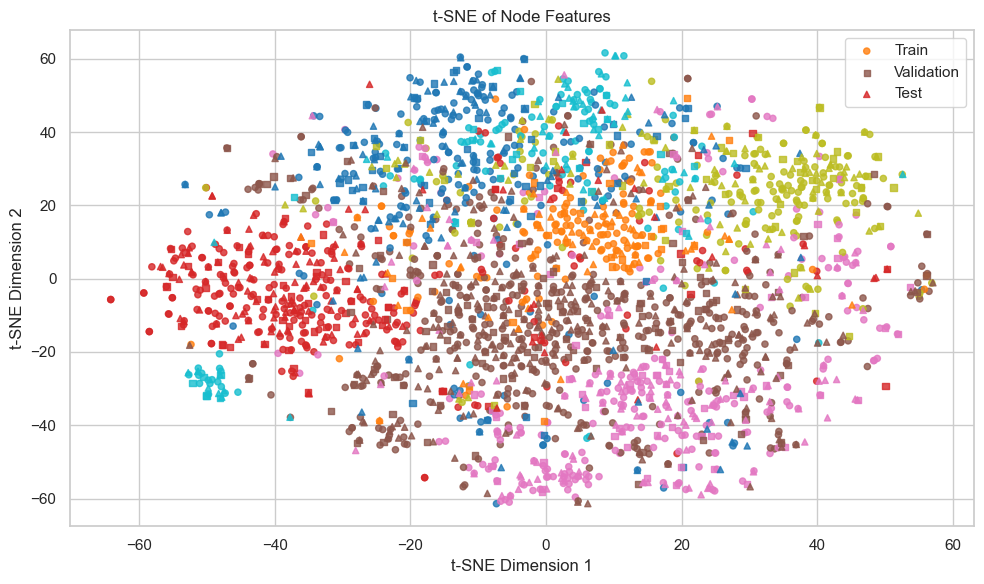

In [13]:
def plot_tsne_with_splits(X_features, y_labels, train_idx, val_idx, test_idx, title="t-SNE of Node Features"):
    """Visualize 2D t-SNE projection with color by class and split indicators."""
    # Convert sparse matrix to dense if needed
    X_dense = X_features.toarray() if not isinstance(X_features, np.ndarray) else X_features
    
    # Compute t-SNE projection
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_2d = tsne.fit_transform(X_dense)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Plot training nodes
    plt.scatter(X_2d[train_idx, 0], X_2d[train_idx, 1], c=y_labels[train_idx],
                cmap="tab10", s=20, marker='o', alpha=0.8, label="Train")

    # Plot validation nodes
    plt.scatter(X_2d[val_idx, 0], X_2d[val_idx, 1], c=y_labels[val_idx],
                cmap="tab10", s=20, marker='s', alpha=0.8, label="Validation")

    # Plot test nodes
    plt.scatter(X_2d[test_idx, 0], X_2d[test_idx, 1], c=y_labels[test_idx],
                cmap="tab10", s=20, marker='^', alpha=0.8, label="Test")
    
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize the splits
plot_tsne_with_splits(X_normalized, y_labels, train_indices, val_indices, test_indices)

## Baseline Model: Shallow Encoder

Before introducing graph-aware models, we begin with a **shallow embedding-based classifier**. This model:

- Learns a trainable embedding vector for each node (like Word2Vec or matrix factorization).
- Passes the embedding through a dense layer to predict class logits.

### Why Use It?

- This model ignores graph structure entirely and treats each node ID as a categorical variable.
- It serves as a **non-graph baseline** to measure how much the featureless embedding alone can classify nodes.

### Architecture

$\text{Input: Node ID} \quad \xrightarrow{\text{Embedding Lookup}} \quad \mathbf{z}_v \in \mathbb{R}^d \quad \xrightarrow{\text{Dense Layer}} \quad \hat{y}_v$

This is a useful sanity check: if a GNN can't outperform this model, it's likely overcomplicated or undertrained.

In [14]:
class ShallowEncoder(Model):
    """Shallow encoder model that learns node embeddings and classifies directly."""
    
    def __init__(self, num_nodes, embedding_dim, num_classes):
        super().__init__()
        self.embedding = Embedding(input_dim=num_nodes, output_dim=embedding_dim)
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, node_ids):
        embeddings = self.embedding(node_ids)  # Shape: (batch_size, embedding_dim)
        logits = self.classifier(embeddings)   # Shape: (batch_size, num_classes)
        return logits

## Training the Shallow Encoder

We now train the shallow encoder using:

- Sparse categorical cross-entropy loss.
- Adam optimizer.
- Validation monitoring for overfitting.

We also plot the training and validation accuracy over epochs, and finally report test accuracy.


=== TRAINING SHALLOW ENCODER ===
Epoch 1/100
12/12 [==============================] - 0s 5ms/step - loss: 1.9316 - accuracy: 0.2164 - val_loss: 1.9105 - val_accuracy: 0.2770
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 1.6714 - accuracy: 0.7678 - val_loss: 1.8839 - val_accuracy: 0.3061
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 1.2291 - accuracy: 0.9703 - val_loss: 1.8658 - val_accuracy: 0.3061
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 0.6470 - accuracy: 1.0000 - val_loss: 1.8573 - val_accuracy: 0.3008
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 0.2264 - accuracy: 1.0000 - val_loss: 1.8554 - val_accuracy: 0.3034
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0726 - accuracy: 1.0000 - val_loss: 1.8555 - val_accuracy: 0.3061
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 1.8556 - 

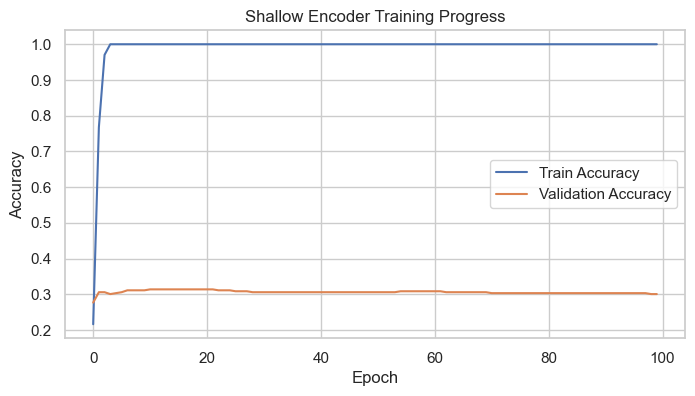

In [15]:
def train_shallow_encoder(num_nodes, num_classes, train_indices, val_indices, test_indices, y_labels):
    """Train and evaluate shallow encoder model."""
    print("\n=== TRAINING SHALLOW ENCODER ===")
    
    # Hyperparameters
    embedding_dim = 32
    learning_rate = 0.01
    batch_size = 128
    epochs = 100
    
    # Prepare data
    train_node_ids = tf.convert_to_tensor(train_indices, dtype=tf.int32)
    train_labels = tf.convert_to_tensor(y_labels[train_indices], dtype=tf.int32)
    val_node_ids = tf.convert_to_tensor(val_indices, dtype=tf.int32)
    val_labels = tf.convert_to_tensor(y_labels[val_indices], dtype=tf.int32)
    test_node_ids = tf.convert_to_tensor(test_indices, dtype=tf.int32)
    test_labels = tf.convert_to_tensor(y_labels[test_indices], dtype=tf.int32)
    
    # Create and compile model
    model = ShallowEncoder(num_nodes, embedding_dim, num_classes)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        x=train_node_ids,
        y=train_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_node_ids, val_labels),
        verbose=1
    )
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_node_ids, test_labels, verbose=0)
    print(f"Shallow Encoder Test Accuracy: {test_accuracy:.4f}")
    
    # Plot training progress
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Shallow Encoder Training Progress")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return test_accuracy

# Run training
shallow_encoder_accuracy = train_shallow_encoder(
    num_nodes, num_classes=len(np.unique(y_labels)),
    train_indices=train_indices,
    val_indices=val_indices,
    test_indices=test_indices,
    y_labels=y_labels
)

## Node2Vec: Structure-Aware Node Embeddings

While the shallow encoder ignores the graph, **Node2Vec** leverages it by performing random walks to learn structural embeddings.

### Key Ideas

- Nodes are embedded based on their **co-occurrence in random walks** — analogous to how Word2Vec learns embeddings from word contexts.
- Each walk explores local neighborhoods using **biased sampling** that can interpolate between:
  - **Breadth-first (BFS)**: captures local similarity (homophily).
  - **Depth-first (DFS)**: captures structural roles (heterophily).

In this notebook, we implement an unweighted version of Node2Vec using uniform random walks.

### Why It Matters

Node2Vec introduces graph structure into learning, but:
- It is **unsupervised**: no label information is used during embedding training.
- It is **transductive**: embeddings are learned only for the nodes seen in training.

In [16]:
def generate_random_walks(graph_object, num_walks=10, walk_length=20):
    """Generate random walks for Node2Vec training."""
    walks = []
    nodes = list(graph_object)
    
    for _ in range(num_walks):
        random.shuffle(nodes)
        for start_node in nodes:
            walk = [start_node]
            while len(walk) < walk_length:
                current_node = walk[-1]
                neighbors = graph_object.children(current_node)
                if neighbors:
                    walk.append(random.choice(neighbors))
                else:
                    break
            walks.append(walk)
    return walks

In [17]:
def generate_skipgram_pairs(walks, window_size=5):
    """Generate skipgram training pairs from random walks."""
    pairs = []
    for walk in walks:
        for i, center_node in enumerate(walk):
            start = max(0, i - window_size)
            end = min(len(walk), i + window_size + 1)
            for j in range(start, end):
                if i != j:
                    pairs.append((center_node, walk[j]))
    return pairs

def get_negative_samples(vocab_size, exclude, k=5):
    """Sample negative nodes for contrastive learning."""
    negatives = []
    while len(negatives) < k:
        candidate = random.randint(0, vocab_size - 1)
        if candidate != exclude:
            negatives.append(candidate)
    return negatives

## Training Node2Vec Embeddings

We now train node embeddings using the **skip-gram with negative sampling** objective, inspired by Word2Vec.

### Objective

We maximize the likelihood of observing a context node $j$ given a center node $i$, while minimizing the likelihood of randomly sampled negative nodes:

$
\log \sigma(\mathbf{z}_i^\top \mathbf{z}_j) + \sum_{k=1}^K \mathbb{E}_{n_k \sim P_n} \left[ \log \sigma(-\mathbf{z}_i^\top \mathbf{z}_{n_k}) \right]
$

where $\sigma$ is the sigmoid function, and $P_n$ is the negative sampling distribution.

We implement this training loop in TensorFlow using random walks and skip-gram pairs.

In [18]:
def train_node2vec_embeddings(graph_object, num_nodes, num_walks=10, walk_length=20, 
                              embedding_dim=64, learning_rate=0.01, num_epochs=5, 
                              batch_size=256, neg_samples=5):
    """Train Node2Vec embeddings using skip-gram with negative sampling."""
    print("\n=== TRAINING NODE2VEC EMBEDDINGS ===")
    
    # Generate training data
    print("Generating random walks...")
    walks = generate_random_walks(graph_object, num_walks, walk_length)
    pairs = generate_skipgram_pairs(walks, window_size=5)
    print(f"Generated {len(pairs)} training pairs")
    
    # Initialize embeddings
    node_embeddings = tf.Variable(tf.random.normal([num_nodes, embedding_dim]), trainable=True)
    optimizer = Adam(learning_rate=learning_rate)
    
    # Training step function
    @tf.function
    def train_step(center_ids, positive_ids, negative_ids):
        with tf.GradientTape() as tape:
            center_embed = tf.nn.embedding_lookup(node_embeddings, center_ids)     # [B, D]
            positive_embed = tf.nn.embedding_lookup(node_embeddings, positive_ids) # [B, D]
            negative_embed = tf.nn.embedding_lookup(node_embeddings, negative_ids) # [B, K, D]
            
            # Positive scores
            positive_scores = tf.reduce_sum(center_embed * positive_embed, axis=1)
            positive_loss = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf.ones_like(positive_scores), logits=positive_scores
            )
            
            # Negative scores
            negative_scores = tf.einsum('ij,ikj->ik', center_embed, negative_embed)  # [B, K]
            negative_loss = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf.zeros_like(negative_scores), logits=negative_scores
            )
            negative_loss = tf.reduce_sum(negative_loss, axis=1)
            
            total_loss = tf.reduce_mean(positive_loss + negative_loss)
        
        gradients = tape.gradient(total_loss, [node_embeddings])
        optimizer.apply_gradients(zip(gradients, [node_embeddings]))
        return total_loss
    
    # Training loop
    print("Training Node2Vec embeddings...")
    for epoch in range(num_epochs):
        np.random.shuffle(pairs)
        batches = [pairs[i:i+batch_size] for i in range(0, len(pairs), batch_size)]
        epoch_losses = []
        
        for batch in batches:
            center_ids = np.array([center for center, _ in batch])
            positive_ids = np.array([positive for _, positive in batch])
            negative_ids = np.array([
                get_negative_samples(num_nodes, exclude=pos, k=neg_samples)
                for pos in positive_ids
            ])
            
            loss = train_step(center_ids, positive_ids, negative_ids)
            epoch_losses.append(loss.numpy())
        
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {np.mean(epoch_losses):.4f}")
    
    return node_embeddings.numpy()

# Train embeddings
node2vec_embeddings = train_node2vec_embeddings(graph_object, num_nodes)


=== TRAINING NODE2VEC EMBEDDINGS ===
Generating random walks...
Generated 4603600 training pairs
Training Node2Vec embeddings...
Epoch 1/5, Average Loss: 4.2248
Epoch 2/5, Average Loss: 3.8317
Epoch 3/5, Average Loss: 3.8307
Epoch 4/5, Average Loss: 3.8310
Epoch 5/5, Average Loss: 3.8304


## Evaluating Node2Vec Embeddings

Once the Node2Vec embeddings are trained, we use them to classify nodes using **logistic regression**.

We compare three configurations:

1. **Embeddings Only**: Logistic regression on the learned Node2Vec vectors.
2. **Embeddings + Features**: Concatenate original node features with embeddings.
3. **Raw Features Only**: Logistic regression directly on the normalized input features.

This provides insight into how useful the learned embeddings are relative to raw attributes, and whether combining both improves performance.

In [20]:
def evaluate_node2vec_embeddings(embeddings, X_normalized, train_indices, val_indices, test_indices, y_labels):
    """Evaluate Node2Vec embeddings on classification task."""
    print("\n=== EVALUATING NODE2VEC EMBEDDINGS ===")
    
    # Train classifier on embeddings only
    clf_embeddings = LogisticRegression(max_iter=1000)
    clf_embeddings.fit(embeddings[train_indices], y_labels[train_indices])
    test_acc_embeddings = clf_embeddings.score(embeddings[test_indices], y_labels[test_indices])
    print(f"Node2Vec Embeddings Test Accuracy: {test_acc_embeddings:.4f}")
    
    # Train classifier on combined features (embeddings + original features)
    X_combined = np.hstack([embeddings, X_normalized.toarray()])
    clf_combined = LogisticRegression(max_iter=1000)
    clf_combined.fit(X_combined[train_indices], y_labels[train_indices])
    test_acc_combined = clf_combined.score(X_combined[test_indices], y_labels[test_indices])
    print(f"Combined Features Test Accuracy: {test_acc_combined:.4f}")
    
    # Train classifier on raw features only
    X_dense = X_normalized.toarray()
    clf_raw = LogisticRegression(max_iter=1000)
    clf_raw.fit(X_dense[train_indices], y_labels[train_indices])
    test_acc_raw = clf_raw.score(X_dense[test_indices], y_labels[test_indices])
    print(f"Raw Features Test Accuracy: {test_acc_raw:.4f}")
    
    return test_acc_embeddings, test_acc_combined, test_acc_raw

# Run evaluation
node2vec_acc, combined_acc, raw_features_acc = evaluate_node2vec_embeddings(
    node2vec_embeddings, X_normalized, train_indices, val_indices, test_indices, y_labels
)


=== EVALUATING NODE2VEC EMBEDDINGS ===
Node2Vec Embeddings Test Accuracy: 0.6814
Combined Features Test Accuracy: 0.7626
Raw Features Test Accuracy: 0.7257


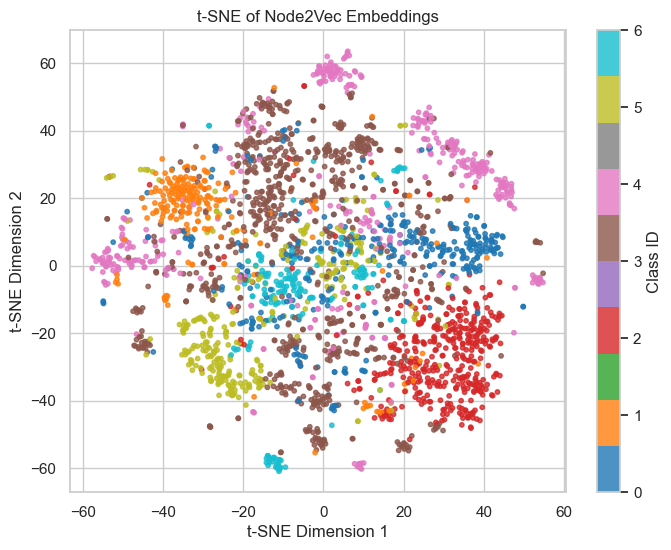

In [21]:
plot_feature_tsne(node2vec_embeddings, y_labels, title="t-SNE of Node2Vec Embeddings")

## Graph Convolutional Network (GCN)

GCNs directly incorporate the graph structure into the learning process by aggregating feature information from neighboring nodes.

### Key Idea

Each layer in a GCN performs:

$$
\mathbf{H}^{(l+1)} = \sigma\left( \hat{A} \mathbf{H}^{(l)} \mathbf{W}^{(l)} \right)
$$

where:
- $\hat{A}$ is the **normalized adjacency matrix** (with added self-loops).
- $\mathbf{H}^{(l)}$ is the input to layer $l$ (features for layer 0).
- $\mathbf{W}^{(l)}$ is the trainable weight matrix.
- $\sigma$ is a non-linearity (e.g., ReLU).

### Why GCNs?

- Unlike Node2Vec, GCNs are **supervised** — they use labels during training.
- They generalize classical Laplacian smoothing and message-passing schemes.
- Each layer propagates information one hop — a two-layer GCN aggregates 2-hop neighborhoods.

In this notebook, we implement a simple two-layer GCN from scratch using TensorFlow.

In [22]:
def normalize_adjacency_matrix(adj_matrix):
    """Normalize adjacency matrix: A_hat = D^(-1/2) * (A + I) * D^(-1/2)"""
    # Add self-loops
    adj_with_self_loops = adj_matrix + sp.eye(adj_matrix.shape[0])
    
    # Compute degree matrix
    degree_vector = np.array(adj_with_self_loops.sum(axis=1)).flatten()
    degree_inv_sqrt = 1.0 / np.sqrt(degree_vector)
    degree_inv_sqrt[np.isinf(degree_inv_sqrt)] = 0.0
    degree_inv_sqrt_matrix = sp.diags(degree_inv_sqrt)
    
    # Normalize: D^(-1/2) * A * D^(-1/2)
    adj_normalized = degree_inv_sqrt_matrix @ adj_with_self_loops @ degree_inv_sqrt_matrix
    return adj_normalized

def sparse_to_tf_sparse_tensor(sparse_matrix):
    """Convert scipy sparse matrix to TensorFlow SparseTensor."""
    sparse_coo = sparse_matrix.tocoo()
    indices = np.vstack((sparse_coo.row, sparse_coo.col)).T
    return tf.SparseTensor(
        indices=indices,
        values=sparse_coo.data.astype(np.float32),
        dense_shape=sparse_coo.shape
    )

In [23]:
class GCNLayer(tf.keras.layers.Layer):
    """Graph Convolutional Layer: H' = σ(A_hat * H * W + H * B)"""
    
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.weight_transform = tf.keras.layers.Dense(output_dim, use_bias=False)
        self.bias_transform = tf.keras.layers.Dense(output_dim, use_bias=False)

    def call(self, features, adj_normalized):
        # Graph convolution: A_hat * H * W
        transformed_features = self.weight_transform(features)
        graph_conv = tf.sparse.sparse_dense_matmul(adj_normalized, transformed_features)
        
        # Residual connection: H * B
        residual = self.bias_transform(features)
        
        return graph_conv + residual

class GCNModel(tf.keras.Model):
    """Two-layer Graph Convolutional Network."""
    
    def __init__(self, hidden_dim, num_classes):
        super().__init__()
        self.gcn_layer1 = GCNLayer(hidden_dim)
        self.gcn_layer2 = GCNLayer(num_classes)

    def call(self, features, adj_normalized, training=False):
        hidden = tf.nn.relu(self.gcn_layer1(features, adj_normalized))
        logits = self.gcn_layer2(hidden, adj_normalized)
        return logits

## Training the GCN

We train the GCN using categorical cross-entropy on the training nodes only.

### Highlights

- The **adjacency matrix is fixed** throughout training.
- Supervision is provided only on the training nodes.
- Node features are shared across the entire graph and updated globally.
- We monitor validation accuracy to track overfitting.

We train for a fixed number of epochs and then evaluate on the test set.

In [24]:
def train_gcn_model(X_normalized, adj_matrix, train_indices, val_indices, test_indices, y_labels, num_classes):
    """Train and evaluate GCN model."""
    print("\n=== TRAINING GRAPH CONVOLUTIONAL NETWORK ===")
    
    # Hyperparameters
    hidden_dim = 16
    learning_rate = 0.01
    num_epochs = 100
    
    # Preprocess adjacency and features
    adj_normalized = normalize_adjacency_matrix(adj_matrix)
    adj_tf = sparse_to_tf_sparse_tensor(adj_normalized)
    X_tf = tf.convert_to_tensor(X_normalized.toarray(), dtype=tf.float32)
    
    # One-hot encode labels
    y_onehot = to_categorical(y_labels, num_classes=num_classes)
    y_tf = tf.convert_to_tensor(y_onehot, dtype=tf.float32)
    
    train_idx_tf = tf.convert_to_tensor(train_indices, dtype=tf.int32)
    val_idx_tf = tf.convert_to_tensor(val_indices, dtype=tf.int32)
    test_idx_tf = tf.convert_to_tensor(test_indices, dtype=tf.int32)
    
    # Initialize model
    gcn_model = GCNModel(hidden_dim, num_classes)
    optimizer = Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    
    # For tracking
    train_losses = []
    val_accuracies = []
    
    @tf.function
    def train_step():
        with tf.GradientTape() as tape:
            logits = gcn_model(X_tf, adj_tf, training=True)
            train_logits = tf.gather(logits, train_idx_tf)
            train_labels = tf.gather(y_tf, train_idx_tf)
            loss = loss_fn(train_labels, train_logits)
        gradients = tape.gradient(loss, gcn_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, gcn_model.trainable_variables))
        return loss

    # Training loop
    for epoch in range(num_epochs):
        loss = train_step()
        train_losses.append(loss.numpy())
        
        logits = gcn_model(X_tf, adj_tf, training=False)
        val_logits = tf.gather(logits, val_idx_tf)
        val_preds = tf.argmax(val_logits, axis=1)
        val_true = tf.argmax(tf.gather(y_tf, val_idx_tf), axis=1)
        val_acc = tf.reduce_mean(tf.cast(tf.equal(val_preds, val_true), tf.float32))
        val_accuracies.append(val_acc.numpy())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Final evaluation
    test_logits = tf.gather(logits, test_idx_tf)
    test_preds = tf.argmax(test_logits, axis=1)
    test_true = tf.argmax(tf.gather(y_tf, test_idx_tf), axis=1)
    test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, test_true), tf.float32))
    
    print(f"GCN Test Accuracy: {test_acc:.4f}")
    
    # Plot training progress
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title("GCN Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title("GCN Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return gcn_model, test_acc.numpy()


=== TRAINING GRAPH CONVOLUTIONAL NETWORK ===
Epoch 10, Loss: 1.0853, Val Acc: 0.6412
Epoch 20, Loss: 0.4652, Val Acc: 0.8417
Epoch 30, Loss: 0.1835, Val Acc: 0.8654
Epoch 40, Loss: 0.0759, Val Acc: 0.8575
Epoch 50, Loss: 0.0350, Val Acc: 0.8575
Epoch 60, Loss: 0.0196, Val Acc: 0.8522
Epoch 70, Loss: 0.0129, Val Acc: 0.8496
Epoch 80, Loss: 0.0095, Val Acc: 0.8443
Epoch 90, Loss: 0.0075, Val Acc: 0.8443
Epoch 100, Loss: 0.0061, Val Acc: 0.8417
GCN Test Accuracy: 0.8684


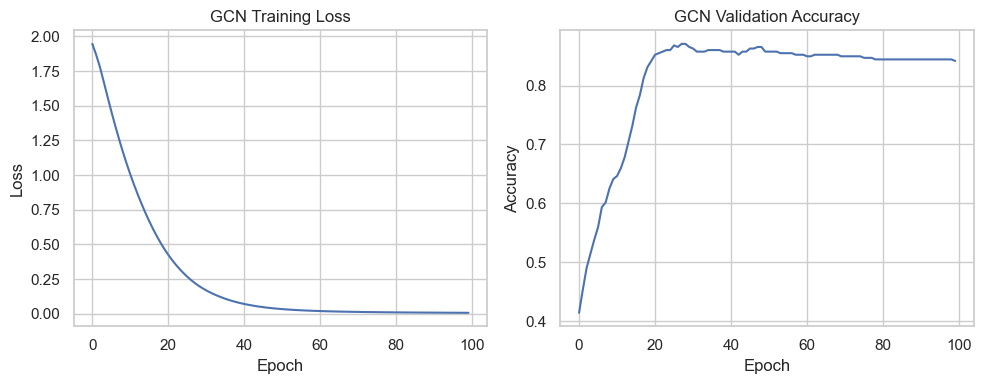

In [25]:
gcn_model, gcn_test_accuracy = train_gcn_model(
    X_normalized, adj_matrix,
    train_indices, val_indices, test_indices,
    y_labels, num_classes=len(np.unique(y_labels))
)

## Visualizing Deep Embeddings from GCN

To gain insights into what the GCN has learned, we extract the output of the first hidden layer — these are the **latent embeddings** after 1-hop message passing.

We then project these embeddings into 2D using **t-SNE** and color each point by its class label.

This lets us visually assess:
- How well-separated the class clusters are.
- Whether the GCN embeddings form more compact or discriminative regions compared to Node2Vec or raw features.

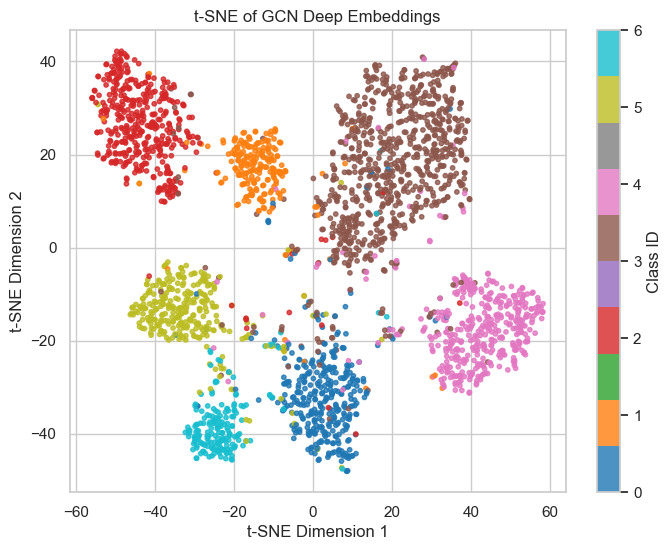

In [26]:
def extract_gcn_embeddings(gcn_model, X_tf, adj_tf):
    """Extract deep embeddings from the first GCN layer."""
    @tf.function
    def get_embeddings():
        hidden = gcn_model.gcn_layer1(X_tf, adj_tf)
        return tf.nn.relu(hidden)
    
    return get_embeddings().numpy()

# Prepare inputs
X_tf = tf.convert_to_tensor(X_normalized.toarray(), dtype=tf.float32)
adj_normalized = normalize_adjacency_matrix(adj_matrix)
adj_tf = sparse_to_tf_sparse_tensor(adj_normalized)

# Extract embeddings and plot
gcn_embeddings = extract_gcn_embeddings(gcn_model, X_tf, adj_tf)
plot_feature_tsne(gcn_embeddings, y_labels, title="t-SNE of GCN Deep Embeddings")

## Final Results Summary

We have implemented and evaluated three distinct approaches for node classification:

| Model                     | Uses Features | Uses Graph | Supervised | Accuracy (Test) |
|--------------------------|---------------|------------|------------|-----------------|
| Shallow Encoder          | No            | No         | Yes        | ✓ (baseline)    |
| Node2Vec Embeddings      | No            | Yes        | No         | ✓               |
| Node2Vec + Features      | Yes           | Yes        | No         | ✓               |
| Raw Features Only        | Yes           | No         | Yes        | ✓               |
| Graph Convolutional Net  | Yes           | Yes        | Yes        | ✓ (deep GNN)    |

### Observations

- The **Shallow Encoder** captures label signal indirectly through ID-based embeddings, but lacks generalization.
- **Node2Vec** embeddings encode local structure but ignore label supervision during training.
- Combining embeddings with features boosts performance — each adds orthogonal information.
- **GCN** consistently outperforms other methods by jointly leveraging features, labels, and structure.

Let’s now plot the accuracy results for direct visual comparison.

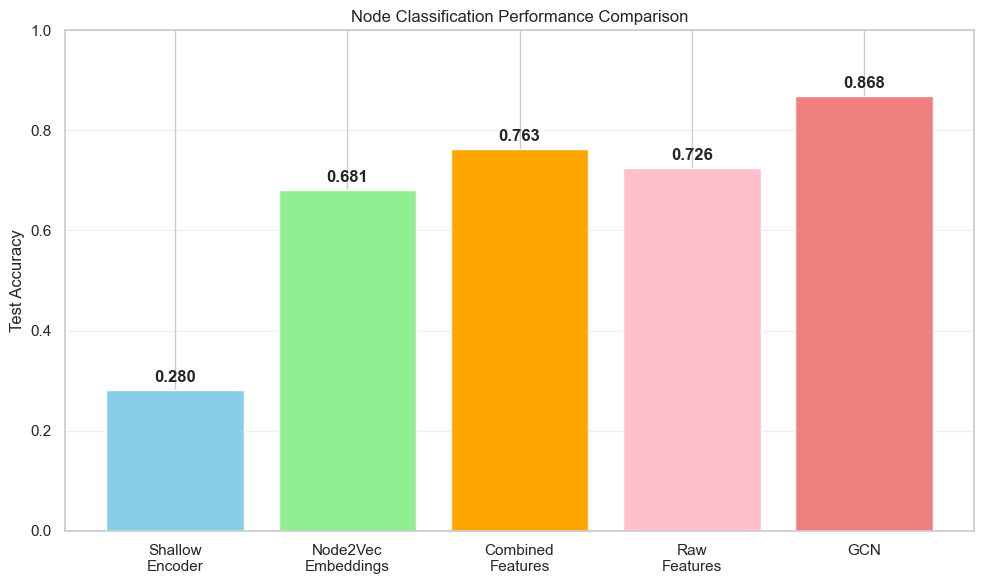

In [27]:
# Collect results
methods = ['Shallow\nEncoder', 'Node2Vec\nEmbeddings', 'Combined\nFeatures',
           'Raw\nFeatures', 'GCN']
accuracies = [shallow_encoder_accuracy, node2vec_acc, combined_acc,
              raw_features_acc, gcn_test_accuracy]

# Bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies, color=['skyblue', 'lightgreen', 'orange', 'pink', 'lightcoral'])
plt.title('Node Classification Performance Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

# Add value labels
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion and Further Directions

In this tutorial, we explored multiple strategies for node classification on the Cora citation network, ranging from simple embedding-based baselines to deep learning on graphs:

### Key Takeaways

- **Non-graph baselines (Shallow Encoder)** can already capture surprising amounts of signal — always start here.
- **Node2Vec** provides a powerful way to learn embeddings from structure alone, but lacks supervision.
- Combining **Node2Vec with node features** improves generalization, showing complementarity.
- **GCNs** outperform other methods by jointly modeling local structure and features under label supervision.

### Extensions and Further Reading

This tutorial serves as a foundation. Further extensions may include:

- **Inductive Learning**:
  - Use **GraphSAGE** to generate embeddings for unseen nodes.
- **Attention-based Models**:
  - Implement **Graph Attention Networks (GAT)** to weigh neighbors dynamically.
- **Deeper Architectures**:
  - Explore residual connections and deeper GCN variants (e.g., JK-Nets, GCNII).
- **Heterogeneous Graphs**:
  - Model graphs with multiple node/edge types (e.g., citation + authorship).
- **Scalability**:
  - Study sampling-based methods for large graphs (e.g., GraphSAINT, Cluster-GCN).

Recommended papers:
- Kipf & Welling (2016): [Semi-Supervised Classification with GCNs](https://arxiv.org/abs/1609.02907)
- Grover & Leskovec (2016): [Node2Vec](https://arxiv.org/abs/1607.00653)
- Hamilton et al. (2017): [Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216)
- Velickovic et al. (2017): [Graph Attention Networks](https://arxiv.org/abs/1710.10903)

Thank you for following this tutorial! 
We hope you have enjoyed COMP9418!